loading necessary libraries

In [1]:
from math import sqrt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import EarlyStopping
from tcn import TCN

loading the data that has been already split as train and test

In [2]:
data = pd.read_csv('datafile/DailyDelhiClimateTrain.csv', parse_dates=True, index_col='date')

In [3]:
data_test = pd.read_csv('datafile/DailyDelhiClimateTest.csv', parse_dates=True, index_col='date')

merging them so we can use it further on

In [4]:
df = pd.concat([data, data_test])

In [5]:
df.shape

(1576, 4)

# primary investigation on the dataframe

In [6]:
df.head(10)

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
2013-01-06,7.000000,82.800000,1.480000,1018.000000
2013-01-07,7.000000,78.600000,6.300000,1020.000000
2013-01-08,8.857143,63.714286,7.142857,1018.714286
2013-01-09,14.000000,51.250000,12.500000,1017.000000


In [7]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1576.000000,1576.000000,1576.000000,1576.000000
mean,25.221918,60.445229,6.899262,1010.593178
std,7.345014,16.979994,4.510725,175.242704
min,6.000000,13.428571,0.000000,-3.041667
25%,18.500000,49.750000,3.700000,1001.875000
50%,27.166667,62.440476,6.363571,1009.055556
75%,31.142857,72.125000,9.262500,1015.200000
max,38.714286,100.000000,42.220000,7679.333333


# exploration of data

In [8]:
# Displaying the first few rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000


In [9]:
# Summary statistics for numerical columns
print("\nSummary statistics for numerical columns:")
print(df.describe())


Summary statistics for numerical columns:
          meantemp     humidity   wind_speed  meanpressure
count  1576.000000  1576.000000  1576.000000   1576.000000
mean     25.221918    60.445229     6.899262   1010.593178
std       7.345014    16.979994     4.510725    175.242704
min       6.000000    13.428571     0.000000     -3.041667
25%      18.500000    49.750000     3.700000   1001.875000
50%      27.166667    62.440476     6.363571   1009.055556
75%      31.142857    72.125000     9.262500   1015.200000
max      38.714286   100.000000    42.220000   7679.333333


In [10]:
# Data type information and missing values
print("\nData types and missing values:")
print(data.info())


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB
None


i dont have any missing values so i can proceed

In [11]:
# Correlation matrix
correlation_matrix = data.corr()

Im creating a heatmap to visualize the correlations between weather variables.
Heatmap helps us understand how different parameters, like temperature, humidity,
wind speed, and precipitation, are relavant. Strong correlations are indicated
by brighter colors, while weaker correlations are represented by darker colors.
This visualization aids in feature selection, pattern recognition, and data exploration.

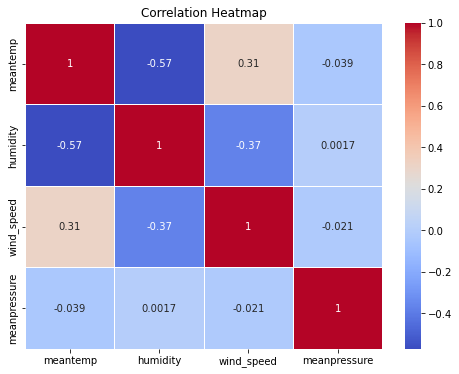

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Analyzing the distribution of numerical columns helps me gain insights into the spread,
central tendencies, and potential outliers within the data. This step help
understand the data's characteristics, which is essential for selecting appropriate
statistical methods and identifying any data anomalies.

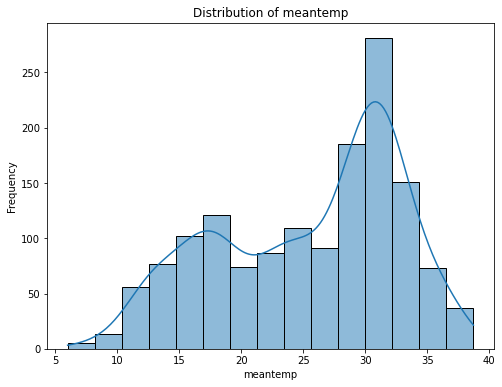

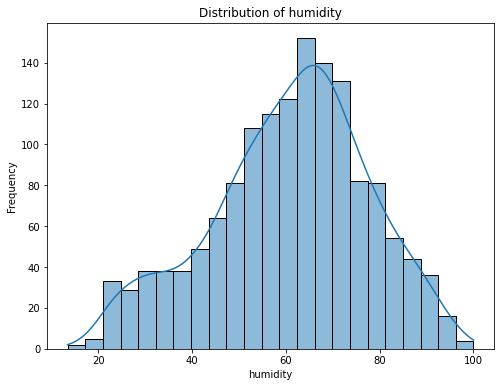

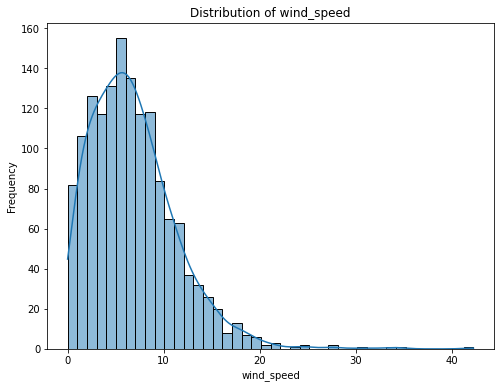

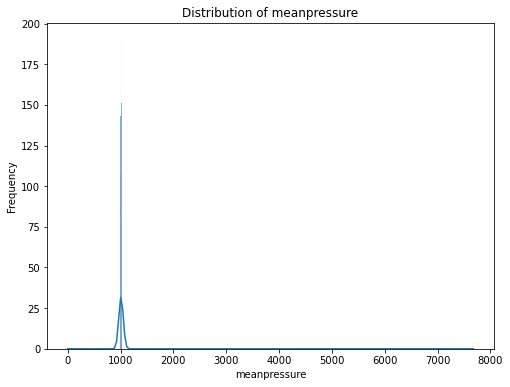

In [13]:
# Distribution of numerical columns
numerical_columns = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[column], kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()



we do not see any or anomalies except the meanpressure, however i do not have detailed knowledge on how i should proceed about the pressure with this specific data. so im going to assume it is not an anomaly based on the brief research i made. 

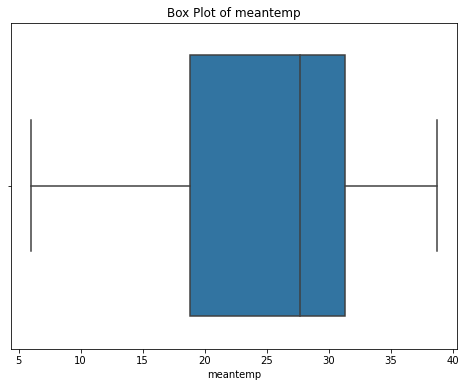

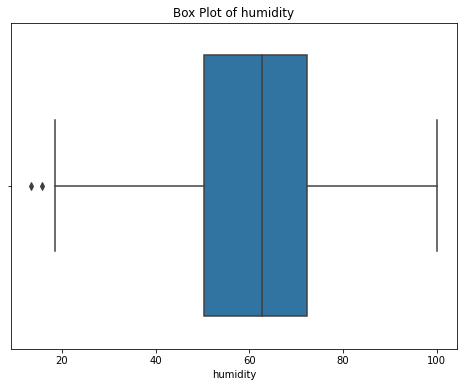

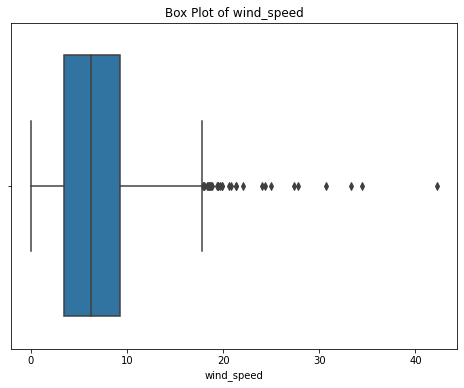

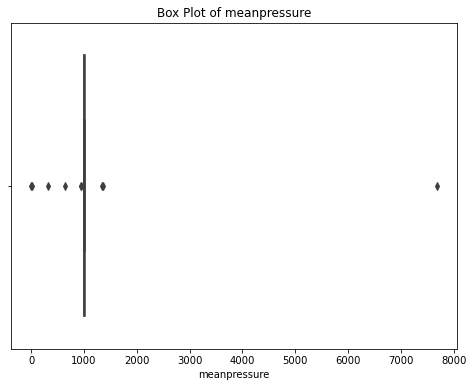

In [14]:
# Box plots to visualize distributions
for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data, x=column)
    plt.title(f"Box Plot of {column}")
    plt.xlabel(column)
    plt.show()

here in the box plot we can see some outliers however nothing out of the ordinary

below i imported time series generator to use later on in the tcn

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

here im writing a function to do necessary preprocessing steps for my data, i did scaling and splitting to explain briefly.

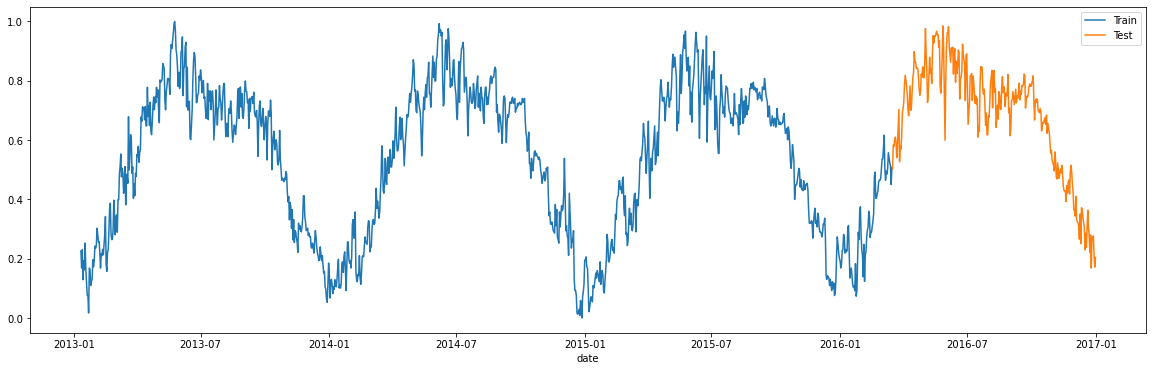

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_weather_data(df, columns, perc_train, timesteps, steps_to_predict, split=True):
    # Remove the year 2017 (reserved for testing)
    df = df[df.index.year != 2017]

    # Select the specified columns for preprocessing
    df_internal = df[columns]

    # Initialize a Min-Max scaler for feature scaling
    X_scaler = MinMaxScaler()

    # Scale the data
    df_X = X_scaler.fit_transform(df_internal)

    # Convert the DataFrame to a NumPy array
    df_y = df_internal.to_numpy()

    # Generate sequences using TimeseriesGenerator
    generator = TimeseriesGenerator(df_X, df_y, length=timesteps, batch_size=steps_to_predict)

    # Extract X and y, reshape, and scale y
    X = np.array([x[0].reshape(timesteps, x[0].shape[-1]) for x in generator])
    y = np.array([x[1][0][0].reshape(1) for x in generator])

    y_scaler = MinMaxScaler()
    y = y_scaler.fit_transform(y)

    if split:
        # Split data based on the percentage specified
        size_train = int(len(X) * perc_train)
        X_train = X[:size_train]
        y_train = y[:size_train]
        X_test = X[size_train:]
        y_test = y[size_train:]

        # Visualize the training and testing data
        plt.figure(figsize=(20, 6))
        sns.lineplot(x=df_internal[timesteps:len(y_train) + timesteps].index, y=y_train[:, 0], label='Train')
        sns.lineplot(x=df_internal[len(y_train) + timesteps:].index, y=y_test[:, 0], label='Test')
        plt.show()

        # Return preprocessed data and scalers for inverse scaling
        return X_train, X_test, y_train, y_test, X_scaler, y_scaler
    else:
        # Return all data for training
        X_train = X
        y_train = y
        return X_train, y_train, X_scaler, y_scaler

# Define the columns to use
columns_to_use = ["meantemp", "humidity", "wind_speed", "meanpressure"]

# Specify preprocessing parameters
perc_train = 0.8
timesteps = 10  # Adjust as needed
steps_to_predict = 1  # Adjust as needed

# Call the preprocessing function
X_train, X_test, y_train, y_test, X_scaler, y_scaler = preprocess_weather_data(df, columns_to_use, perc_train, timesteps, steps_to_predict)


Below, primarily i have defined an evaluation function to evaluate my model after i have trained it.

In [17]:
# Defining a function to evaluate and visualize model performance
def evaluate_model(model, X_test, y_test, X_scaler, y_scaler):
    # Making predictions
    y_pred = model.predict(X_test)
    
    # Inversing scale the predictions
    y_pred = y_scaler.inverse_transform(y_pred)
    
    # Inversing scale the true values
    y_test = y_scaler.inverse_transform(y_test)
    
    # Calculating R-squared and RMSE
    r2 = r2_score(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    
    # Plotting the true vs. predicted values
    plt.figure(figsize=(15, 6))
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    sns.lineplot(x=df.index[-len(y_test):], y=y_test[:,0], label='Test')
    sns.lineplot(x=df.index[-len(y_test):], y=y_pred[:,0], label='Predicted')
    plt.title('True vs. Predicted Values')
    plt.show()
    
    # Printing model metrics
    print('Model Metrics:')
    print(f'R2 Score: {r2}')
    print(f'RMSE: {rmse}')
    
    return r2, rmse

I have defined two models an LSTM model and a Temporal Convolutional Network model. For optimizing the training process of these models, i've chosen the Adam optimizer. This choice enables efficient gradient-based optimization, which is vital for the success of the models. for the loss i have decided to use MSE loss function. MSE is a commonly used loss function for regression tasks like ours, where the objective is to minimize the squared differences between the predicted outputs and the actual values. Using MSE allows us to rigorously measure and address the prediction errors made by our models, a fundamental step in enhancing their accuracy and facilitating convergence during the training process."

hidden layers like those in Dense (fully connected) layers typically use a linear activation function, which means there's no non-linearity applied. 
For regression tasks Keras generally uses no activation function, which is equivalent to a linear activation. 

In [18]:
# Specification of the input shape for the models
input_shape = (X_train.shape[1], X_train.shape[2])

In [19]:
# Defining an LSTM model
def create_lstm_model(input_shape, patience=None):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    if patience:
        early_stop = EarlyStopping(monitor='val_loss', patience=patience)
        return model, early_stop
    else:
        return model

In [20]:
# Defining a TCN model with approximately 20,000 parameters
# The residual connections are present implicitly through the use of the return_sequences=True argument in the TCN layers.
def create_tcn_model(input_shape, num_params=20000, patience=None):
    # Calculate the number of layers required to achieve the desired number of parameters
    num_layers = int(np.log2(num_params / (input_shape[1] * 2)))
    
    model = Sequential()
    for _ in range(num_layers):
        model.add(TCN(return_sequences=True, input_shape=input_shape))
    model.add(TCN(return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    if patience:
        early_stop = EarlyStopping(monitor='val_loss', patience=patience)
        return model, early_stop
    else:
        return model

In [21]:
# Creating and compiling the LSTM and TCN models
lstm_model, early_stop_lstm = create_lstm_model(input_shape, patience=10)
tcn_model, early_stop_tcn = create_tcn_model(input_shape, num_params=20000, patience=10)


In [22]:
# Train the models (adjust epochs and batch size as needed)
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stop_lstm])
tcn_history = tcn_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stop_tcn])

Epoch 1/50
15/15 [==============================] - 4s 80ms/step - loss: 0.0896 - val_loss: 0.0189
Epoch 2/50
15/15 [==============================] - 0s 22ms/step - loss: 0.0165 - val_loss: 0.0046
Epoch 3/50
15/15 [==============================] - 0s 20ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 4/50
15/15 [==============================] - 0s 20ms/step - loss: 0.0069 - val_loss: 0.0045
Epoch 5/50
15/15 [==============================] - 1s 36ms/step - loss: 0.0065 - val_loss: 0.0042
Epoch 6/50
15/15 [==============================] - 0s 22ms/step - loss: 0.0063 - val_loss: 0.0042
Epoch 7/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0063 - val_loss: 0.0041
Epoch 8/50
15/15 [==============================] - 1s 36ms/step - loss: 0.0063 - val_loss: 0.0040
Epoch 9/50
15/15 [==============================] - 0s 21ms/step - loss: 0.0060 - val_loss: 0.0040
Epoch 10/50
15/15 [==============================] - 0s 22ms/step - loss: 0.0059 - val_loss: 0.0040
Epoch 11/

15/15 [==============================] - 6s 392ms/step - loss: 0.0102 - val_loss: 0.0084
Epoch 33/50
15/15 [==============================] - 7s 435ms/step - loss: 0.0083 - val_loss: 0.0066
Epoch 34/50
15/15 [==============================] - 6s 396ms/step - loss: 0.0079 - val_loss: 0.0068
Epoch 35/50
15/15 [==============================] - 6s 393ms/step - loss: 0.0072 - val_loss: 0.0078
Epoch 36/50
15/15 [==============================] - 6s 393ms/step - loss: 0.0088 - val_loss: 0.0063
Epoch 37/50
15/15 [==============================] - 6s 391ms/step - loss: 0.0078 - val_loss: 0.0063
Epoch 38/50
15/15 [==============================] - 6s 398ms/step - loss: 0.0074 - val_loss: 0.0061
Epoch 39/50
15/15 [==============================] - 6s 397ms/step - loss: 0.0070 - val_loss: 0.0062
Epoch 40/50
15/15 [==============================] - 6s 397ms/step - loss: 0.0069 - val_loss: 0.0063
Epoch 41/50
15/15 [==============================] - 6s 392ms/step - loss: 0.0073 - val_loss: 0.0065
Ep

LSTM Model Performance:
10/10 [==============================] - 1s 5ms/step


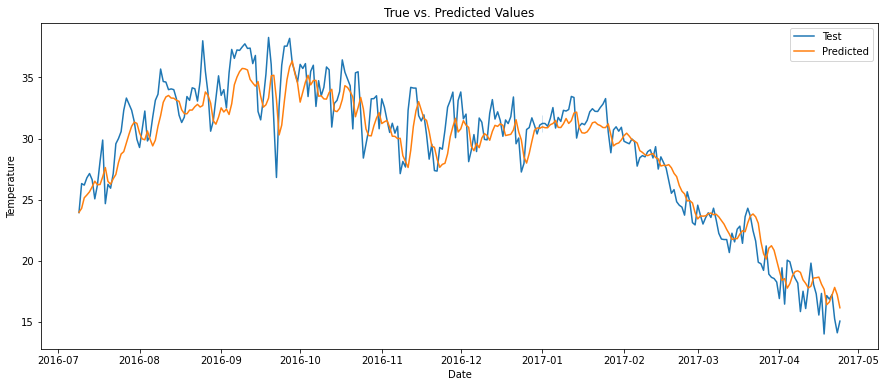

Model Metrics:
R2 Score: 0.8878933651698229
RMSE: 1.860106358357165
TCN Model Performance:
10/10 [==============================] - 3s 58ms/step


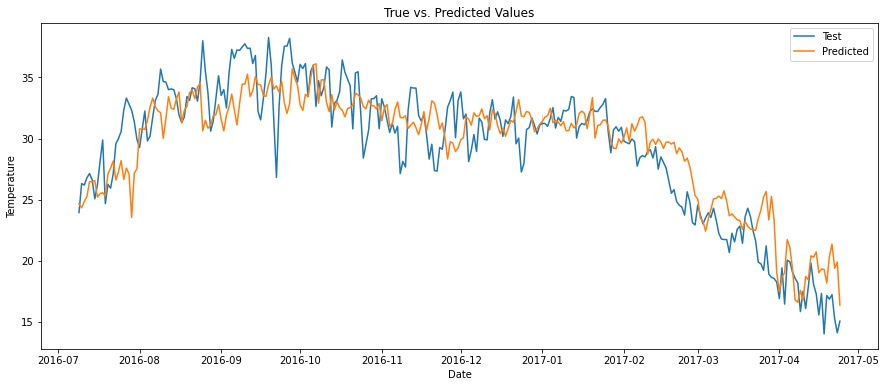

Model Metrics:
R2 Score: 0.7797846194722566
RMSE: 2.6070294865191794


In [23]:
# Evaluate and visualize model performance
print("LSTM Model Performance:")
r2_lstm, rmse_lstm = evaluate_model(lstm_model, X_test, y_test, X_scaler, y_scaler)

print("TCN Model Performance:")
r2_tcn, rmse_tcn = evaluate_model(tcn_model, X_test, y_test, X_scaler, y_scaler)